<a href="https://colab.research.google.com/github/VStee1e/EEG-Location-Prediction/blob/main/Contrastive_Learning_Shift_Invariant_k_means_with_CUE_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

In [1]:
!pip install mne
!pip install BOWaves
import mne
import numpy as np
import scipy.io as sio
import os
import fnmatch
# import numpy as np
# import mne
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
from BOWaves.sikmeans import sikmeans_core
from BOWaves.utilities.wrappers import si_pairwise_distances_argmin_min
from BOWaves.utilities.wrappers import si_pairwise_distances_argmin_min_scipyvq as do_not_use
import scipy.signal as signal

from scipy.signal import fftconvolve
from scipy.cluster import vq
import numbers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.4 MB/s eta 0:00:00


Load data

In [2]:
sig_fn_1 = 'cue_subj_01_chunked.npz'
fl = 12
sfreq = 512
n_components = 63
sig_fns = [sig_fn_1]
dm_lis = []
mm_lis = []
N_ = []
break
for i in range(fl):
    fn = 'icaweights0' + str(i+1) + '.mat'
    dm_lis.append(fn)
for i in range(fl):
    fn = 'icawinv0' + str(i+1) + '.mat'
    mm_lis.append(fn)
dm1, dm2, dm3, dm4, dm5, dm6, dm7, dm8, dm9, dm10, dm11, dm12 = dm_lis
mm1, mm2, mm3, mm4, mm5, mm6, mm7, mm8, mm9, mm10, mm11, mm12 = mm_lis
for i in range(len(dm_lis)):
    dm_lis[i] = sio.loadmat(dm_lis[i])
    mm_lis[i] = sio.loadmat(mm_lis[i])
for i in range(len(dm_lis)):
    # Access the arrays within the dictionaries using the appropriate keys
    # Assuming 'icaweights' and 'icawinv' are the keys for the arrays in the .mat files
    N_.append(np.concatenate((dm_lis[i]['icaweights'][1,:], mm_lis[i]['icawinv'][:,1])))

SyntaxError: 'break' outside loop (<ipython-input-2-1b4e6a257fed>, line 9)

Create topo maps

In [ ]:
info = mne.create_info(64, sfreq, ch_types='eeg')

# Get the channel names from the biosemi256 montage
biosemi256_montage = mne.channels.make_standard_montage('biosemi128')
biosemi256_channel_names = biosemi256_montage.ch_names

# Select the first 63 channel names to match your data
relevant_channel_names = biosemi256_channel_names[:64]

# Rename the channels in your info object
mapping = {str(i): name for i, name in enumerate(relevant_channel_names)}
info.rename_channels(mapping)

# Now you can set the montage
info.set_montage('biosemi128')
for j in range(n_components):
    mne.viz.plot_topomap(N_[0][j], info)

Grab Windows

In [3]:
def check_rng(seed):
    """Turn seed into a np.random.Generator instance

    Parameters
    ----------
    seed : None, int or instance of Generator
        If seed is None, return the Generator using the OS entropy.
        If seed is an int, return a new Generator instance seeded with seed.
        If seed is already a Generator instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None:
        return np.random.default_rng()
    if isinstance(seed, numbers.Integral):
        seed = np.random.SeedSequence(seed)
        return np.random.default_rng(seed)
    if isinstance(seed, np.random.Generator):
        return seed

    raise ValueError('%r cannot be used to seed a numpy.random.Generator'
                     ' instance' % seed)

def pick_random_windows(X, n_windows, window_length, rng=None):
    """
    It picks windows randomly from each row of `X`.

    Parameters
    ----------
    X (numpy.ndarray):
        Matrix with data samples in its rows.
    n_windows (int):
        Number of unique windows per sample. Windows are taken randomly, but
        each window is different.
    window_length (int):
        Lenght of the window
    rng (int, Generator instance, or None):
        Determines random number generation for picking the windows. Use an
        int to make the randomness deterministic.

    Returns
    -------
    Y (numpy.ndarray):
        Windows of rows of `X` selected randomly

    Shapes
    ------
    X : (`n_samples`, `n_features`)
    Y : (`n_samples`, `n_windows`, `window_length`)
    """

    if X.ndim == 1:
        X = X[np.newaxis, :]

    n_samples, n_features = X.shape
    n_bytes_per_element = X.dtype.itemsize
    n_offsets = n_features - window_length + 1
    peak_memory_use = n_samples * n_offsets * window_length \
                      * n_bytes_per_element

    rng = check_rng(rng)

In [4]:
from BOWaves.utilities.sikmeans_utils import pick_random_windows as prw

In [6]:
# pick_random_windows(S_,2000,2)
windows = []
for i, filename in enumerate(sig_fns):
  time_ser = np.load(filename, allow_pickle=True)['icaact'][0]
  print(time_ser.shape)
  for k in range(n_components):
    windows.append(prw(time_ser, 500, 2, None))
# print(windows)
win_across_ics = np.vstack(windows)
print(win_across_ics.shape)
# chunks = si_pairwise_distances_argmin_min_scipyvq(win_reshaped, centroids, 'cosine', np.linalg.norm(win, axis=1))


(63, 7680)
(3969, 500, 2)


In [7]:
win_across_ics_reshaped = win_across_ics.reshape(win_across_ics.shape[0], -1)
win_across_ics_reshaped.shape

(3969, 1000)

In [8]:
import sys
import numpy as np

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.utils.extmath import row_norms
from sklearn.preprocessing import normalize
from scipy.cluster.vq import vq

def shi_sgi_pairwise_distances_argmin_min_scipyvq(X, centroids, metric):
    """
    Shift-invariant wrapper of argmin_min, but using scipy's vq instead.
    Ablation based on 3rd comment of: https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn

    The scipy vq call by default uses the Euclidean metric. I'll implement that first and then add cosine
    by just normalizing things before passing it in.

    Parameters:
    X (numpy.ndarray):
        Training data. Rows of X are samples.
    centroids (numpy.ndarray):
        Centroids of the clusters.
    x_squared_norms (numpy.ndarray):
        Squared Euclidean norm of rows of X. This is used to speed up the
        computation of the Euclidean distances between samples and centroids.
    """

    # TODO - make sure to reproduce with set random seed
    print('Hello from scipy')
    # euclidean_distances() requires 2D

    #first if-else commented out for testing
    #if metric == 'euclidean' and x_squared_norms.ndim == 1:
    #    x_squared_norms = x_squared_norms.reshape(1, -1)
    if centroids.ndim == 1:
        centroids = centroids.reshape(1, -1)

    n_samples, sample_length = X.shape
    centroid_length = centroids.shape[1]
    n_shifts = sample_length - centroid_length + 1

    best_labels = np.empty((n_shifts, n_samples), dtype=int)
    best_distances = np.empty((n_shifts, n_samples))

    if metric == 'euclidean':
      new_centroids = []
      for k in range(centroids):
        cent = centroids[k, :]
        inv_cent = negative(cent)
        dist = pairwise_distances_argmin_min(inv_cent, Y=cent, axis=1, metric='euclidean')
        if dist > 0:
          cent = -2(cent) + 1
        new_centroids.append(cent)
      for shift in range(n_shifts):
          # A bug on sklearn enforces a 2D array
          #XX = x_squared_norms[shift].reshape((n_samples, 1))
          best_labels[shift], best_distances[shift] = \
          vq(X[:, shift:shift+centroid_length], centroids,check_finite=False)
    elif metric == 'cosine':
      # if metric is cosine, just pass in the normalized centroids
      normalized_centroids = normalize(centroids, axis=1)
      # Dedent this for loop to align with the 'if' and 'elif' blocks
      for shift in range(n_shifts):
        best_labels[shift], best_distances[shift] = vq(X[:, shift:shift + centroid_length], normalized_centroids, check_finite=False)
    else:
        sys.exit('%s metric not implemented' % metric)

    # For each sample, find best shift
    best_shifts = np.argmin(best_distances, axis=0)
    best_labels = best_labels[best_shifts, np.arange(n_samples)]
    best_distances = best_distances[best_shifts, np.arange(n_samples)]

    return best_labels, best_shifts, best_distances

<>:52: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:52: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<ipython-input-8-4893814f3fb4>:52: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  cent = -2(cent) + 1


In [35]:
def si_pairwise_distances_argmin_min_scipyvq(X, centroids, metric, squared_norms):
    """
    Shift-invariant wrapper of argmin_min, but using scipy's vq instead.
    Ablation based on 3rd comment of: https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn

    The scipy vq call by default uses the Euclidean metric. I'll implement that first and then add cosine
    by just normalizing things before passing it in.

    Parameters:
    X (numpy.ndarray):
        Training data. Rows of X are samples.
    centroids (numpy.ndarray):
        Centroids of the clusters.
    x_squared_norms (numpy.ndarray):
        Squared Euclidean norm of rows of X. This is used to speed up the
        computation of the Euclidean distances between samples and centroids.
    """

    # TODO - make sure to reproduce with set random seed
    print('Hello from scipy')
    # euclidean_distances() requires 2D

    #first if-else commented out for testing
    #if metric == 'euclidean' and x_squared_norms.ndim == 1:
    #    x_squared_norms = x_squared_norms.reshape(1, -1)
    if centroids.ndim == 1:
        centroids = centroids.reshape(1, -1)

    n_samples, sample_length = X.shape
    centroid_length = centroids.shape[1]
    n_shifts = sample_length - centroid_length + 1

    best_labels = np.empty((n_shifts, n_samples), dtype=int)
    best_distances = np.empty((n_shifts, n_samples))

    if metric == 'euclidean':
        for shift in range(n_shifts):
            # A bug on sklearn enforces a 2D array
            #XX = x_squared_norms[shift].reshape((n_samples, 1))
            best_labels[shift], best_distances[shift] = \
                vq(X[:, shift:shift+centroid_length], centroids,check_finite=False)
    elif metric == 'cosine':
        # if metric is cosine, just pass in the normalized centroids
        normalized_centroids = normalize(centroids, axis=1)
        for shift in range(n_shifts):
            best_labels[shift], best_distances[shift] = vq(X[:, shift:shift + centroid_length], normalized_centroids, check_finite=False)
    else:
        sys.exit('%s metric not implemented' % metric)

    # For each sample, find best shift
    best_shifts = np.argmin(best_distances, axis=0)
    best_labels = best_labels[best_shifts, np.arange(n_samples)]
    best_distances = best_distances[best_shifts, np.arange(n_samples)]

    return best_labels, best_shifts, best_distances

TypeError: si_pairwise_distances_argmin_min_scipyvq() got an unexpected keyword argument 'squared_norms'

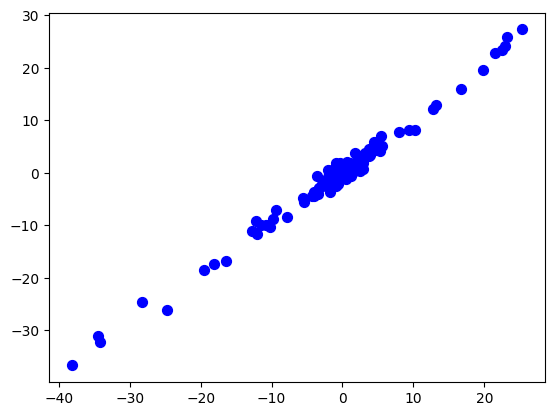

In [77]:
# Calculate centroids (example using k-means)
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
kmeans = KMeans(n_clusters=200, random_state=0, n_init='auto').fit(win_across_ics.reshape(win_across_ics.shape[0], -1))
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=50, marker='o')
# Call the function with the calculated centroids
waveforms = si_pairwise_distances_argmin_min_scipyvq(win_across_ics_reshaped, centroids, 'euclidean', squared_norms=squared_norms)
# sign_inv_waveforms = shi_sgi_pairwise_distances_argmin_min_scipyvq(win_across_ics_reshaped, centroids, 'euclidean')
waves = np.vstack(waveforms)
# sign_inv_waves = np.vstack(sign_inv_waveforms)

In [40]:
len(centroids)
waves.shape

(3, 3969)

In [38]:
# plt.plot(centroids)
fig, axs = plt.subplots(20,10)
for i in range(len(centroids)):
    axs[i].plot(centroids[i])
    axs[i].set_title(f'Centroid {i+1}')

# plt.tight_layout()
plt.ylim(-1,1)
fig.suptitle('Centroids')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

Error in callback <function flush_figures at 0x7c73d3093130> (for post_execute):


KeyboardInterrupt: 

In [ ]:
waves, sign_inv_waves

In [ ]:
waves.shape

Plot Independent Components

In [ ]:
# waveform_dict = pickle.load(open( "models/waveform_dict_"+param_string+".pickle", "rb" ) )
# waveforms = np.vstack( [waveform_dict[d]  for d in segment_info_train])
# ave_shap_cont_per_class =

def plot_codebooks(codebook,spectra,freq, name,titles=None, ncols=None,figsize=(9.5, 8)):
    n = codebook.shape[0]
    if ncols is None:
        if n>8:
            ncols = 8
        else:
            ncols = int(n/2)
    nrows = int(np.ceil(n/ncols))
    fig, axs = plt.subplots(nrows, ncols*2, figsize=figsize)
    axs = np.reshape(axs, (-1,2))
    print(axs.shape)
    for i in range(nrows):
        for j in range(ncols):
            if i*ncols+j < n:
                print(i*ncols+j)
                axs[i, j*2].plot(codebook[i * ncols + j, :])
                if titles is not None:
                    axs[i,j*2].set_title(titles[0][i*ncols+j])
                axs[i, j*2+1].plot(freq,spectra[i * ncols + j])
                axs[i, j*2+1].set_xlim([0,13])
                axs[i, j*2+1].set_xticks(np.arange(0,13,3))
                if titles is not None:
                    axs[i,j*2+1].set_title(titles[1][i*ncols+j])

            axs[i, j*2].axis('off')  # hide axis

    plt.suptitle(name, fontsize=16)
    plt.tight_layout()
    plt.show()
    return fig, axs

plot_codebooks(waves, 10, sfreq, None, ncols=3, figsize=(9.5, 8))
peaks = np.zeros(waveforms.shape[0])
nfft = 4096
n = len(waveforms[0])
freq,spectrum = signal.welch(waveforms[0],fs=sfreq, nfft=nfft,nperseg=int(.95*n),noverlap=int(.9*n))

spectra = np.zeros((waveforms.shape[0],len(freq)))

for i in range(waveforms.shape[0]):
    y = waveforms[i]
    n = len(y)
    freq,spectra[i] = signal.welch(y,sfreq,nfft=nfft,nperseg=int(.95*n),noverlap=int(.9*n))
    peaks[i]= freq[np.argmax(spectra[i])]

plot_codebooks(waves, 10, sfreq, None, ncols=3, figsize=(9.5, 8))
plot_codebooks(waveforms, spectra, freq, None, ncols=4, figsize=(9.5, 8))
toplot=16
for c in range(6):
    wave_idx = np.argsort(-np.abs(ave_shap_cont_per_class[:,c]))
#    wave_idx = np.argsort(-ave_shap_cont_per_class[:,c])
    # wave_str = ['{}{}.{}: int {:.0f}min.'.format('+' if ave_shap_cont_per_class[i,c]>0 else '-' ,(i//200)+1,(i%200)+1,(np.mean(X_train[:,i])/60)**-1, p) for i,p in zip(wave_idx,peaks[wave_idx])]
    # peak_str = ['{:0.1f}Hz'.format(p) for i,p in zip(wave_idx,peaks[wave_idx])]
    plot_codebooks(waveforms[wave_idx[:toplot]],spectra[wave_idx[:toplot]],freq,types[c]+f" ({c+1})",titles=(wave_str,peak_str),ncols=4)

In [25]:
from BOWaves.utilities import wrappers
def si2_pairwise_distances_argmin_min(X, centroids, metric, squared_norms):
    best_labels_b, best_shifts, best_distances = wrappers.si_pairwise_distances_argmin_min(X,
                                                                                           np.vstack((centroids,
                                                                                                      -centroids)),
                                                                                           metric, squared_norms)
    best_signs = np.where(best_labels_b//2 == 0, np.ones_like(best_shifts), np.full_like(best_shifts, -1))
    n_centroids = centroids.shape[0]
    best_labels = best_labels_b % n_centroids

In [34]:
# This code snippet appears to be syntactically correct.
# It is likely missing imports or a function definition for 'si2_pairwise_distances_argmin_min'.
squared_norms = np.linalg.norm(win_across_ics_reshaped, axis=1)
new_waveforms = si2_pairwise_distances_argmin_min(win_across_ics_reshaped, centroids, 'euclidean', squared_norms=squared_norms)

In [46]:
win_across_ics_reshaped.shape, centroids.shape, squared_norms.shape

((3969, 1000), (200, 1000), (3969,))

In [66]:
var = si2_kmeans(win_across_ics_reshaped, 200, len(centroids), 'cosine', 'random', 10, 300, 0.0001, None, False)

<ipython-input-66-88eeec9de1da>:1: ConvergenceWarning: Number of distinct clusters (189) found smaller than n_clusters (200). Possibly due to duplicate points in X.
  var = si2_kmeans(win_across_ics_reshaped, 200, len(centroids), 'cosine', 'random', 10, 300, 0.0001, None, False)


In [80]:
# var_list = [np.array(item) for item in var]
var


(array([[ 0.81688912,  0.04111129, -0.15129964, ...,  1.40922126,
          1.11527051, -0.79004106],
        [ 2.348872  ,  2.4202815 , -0.50116857, ...,  0.45846922,
         -0.15385305, -0.15307719],
        [-0.38990674,  0.01630525,  0.10730635, ...,  2.06557339,
          2.09480195,  0.78575778],
        ...,
        [ 0.13245211,  0.53969174,  0.11932053, ...,  0.26421103,
          1.59934267,  0.86591147],
        [-0.14482186, -0.112158  , -0.23165924, ..., -0.29420961,
          0.15523865,  0.22988985],
        [-0.2387441 , -0.70385383, -0.52790473, ..., -0.01028543,
          0.45206417,  0.02401656]]),
 array([ 23, 114,  58, ...,  58, 100, 187]),
 array([320, 511, 216, ...,   2, 400, 548]),
 array([1.58384366e-01, 3.37139567e-02, 1.18636859e-01, ...,
        3.15400267e-01, 5.55111512e-16, 3.67526316e-01]),
 0.26851470780395176,
 13)

In [64]:
"""Sign-invariant and Shift-invariant k-means"""

import sys
import warnings

import numpy as np
from scipy.cluster.vq import vq


from sklearn.utils.extmath import stable_cumsum, squared_norm, row_norms
from sklearn.exceptions import ConvergenceWarning

from BOWaves.utilities import sikmeans_utils, wrappers
from sklearn.preprocessing import normalize



def init_centroids(X, n_clusters, centroid_length, metric='euclidean',\
    init='k-means++', x_squared_norms=None, rng=None, **kwargs):
    """
    Compute initial centroids

    Parameters
    ----------
    X (numpy.ndarray):
        Training data. Rows are samples.
    n_clusters (int):
        Number of initial seed centroids
    centroid_length (int):
        Length of each centroid
    init ('k-means++', 'random', numpy.ndarray, or a function):
        Method for initialization. If it's a function, it should have this
        call signature:
        centroids, shifts = init(
            X, n_clusters, centroid_length, rng, **kwargs).
        rng must be a Generator instance.
    x_squared_norms (numpy.ndarray or None):
        Equivalent to np.matmul(X, X.T). If None, it would be computed if
        init='kmeans++'.
    rng (Int or Generator instance):
        The generator used to initialize the centroids. Use int to make the
        randomness deterministic.
    **kwargs:
        If init=='kmeans++', the following keyword argument can be used
            n_local_trials (int):
                The number of seeding trials for each centroid (except the first),
                of which the one reducing inertia the most is greedily chosen.
                Set to None to make the number of trials depend logarithmically
                on the number of seeds (2+log(k)); this is the default.


    Returns
    -------
    centroids (numpy.ndarray):
        The centroid seeds
    """

    rng = sikmeans_utils.check_rng(rng)

    n_samples, sample_length = X.shape

    if isinstance(init, str) and init == 'k-means++':
        if isinstance(metric, str) and metric == 'euclidean':
            if x_squared_norms is None:
                x_squared_norms = wrappers.si_row_norms(
                    X, centroid_length, squared=True)
            if len(kwargs) == 0 or 'n_local_trials' not in kwargs:
                n_local_trials = None
            else:
                n_local_trials = kwargs['n_local_trials']
            centroids = _kmeans_plus_plus(
                X, n_clusters, centroid_length, x_squared_norms, rng, n_local_trials)
        else:
            sys.exit("k-means++ is not implemented for non-euclidean metrics")
    elif isinstance(init, str) and init == 'random':
        centroids = _random_init(X, n_clusters, centroid_length,\
            rng)
    elif isinstance(init, str) and init == 'random-energy':
        centroids = _random_energy_init(
            X, n_clusters, centroid_length, rng)
    elif hasattr(init, '__array__'):
        # ensure that the centroids have the same dtype as X
        # this is a requirement of fused types of cython
        centroids = np.array(init, dtype=X.dtype)
    elif callable(init):
        centroids = init(X, n_clusters, centroid_length,
                         rng, **kwargs)
        centroids = np.asarray(centroids, dtype=X.dtype)
    else:
        raise ValueError("the init parameter for the k-means should "
                         "be 'k-means++' or 'random' or an ndarray, "
                         "'%s' (type '%s') was passed." % (init, type(init)))

    return centroids


def _random_init(X, n_clusters, centroid_length, rng):
    n_samples = X.shape[0]
    seeds = rng.permutation(n_samples)[:n_clusters]
    centroids = X[seeds]
    centroids = sikmeans_utils.pick_random_windows(centroids, 1, centroid_length,
                                                   rng).squeeze()

    return centroids



###############################################################################
# Main algorithm

def si2_kmeans(X, n_clusters, centroid_length, metric='cosine',
                               init='random', n_init=10, max_iter=300, tol=1e-4, rng=None, verbose=False):
    """
    Shift-invariant k-means algorithm

    Parameters
    ----------
    X (numpy.ndarray):
        Data matrix with samples in its rows.
    n_clusters (int):
        Number of clusters to form, as well as the number of centroids to find.
    centroid_length (int):
        The length of each centroid.
    metric ('euclidean' or 'cosine'):
        Metric used to compute the distance between samples and cluster centroids. Default: 'euclidean'.
    init ('k-means++', 'random', numpy.ndarray, or a function):
        Method for initialization. If it's a function, it should have this
        call signature:
        centroids, shifts = init(
             X, n_clusters, centroid_length, rng, **kwargs).
        rng must be a Generator instance.
    n_init (int):
        The number of times the algorithm is run with different centroid seeds.
        The final results would be from the iteration where the inertia is the
        lowest.
    max_iter (init):
        Maximum number of iterations the algorithm will be run.
    tol (float):
        Upper bound that the squared euclidean norm of the change in the
        centroids must achieve to declare convergence.
    rng (int, Generator instance or None):
        Determines random number generation for centroid initialization. Use an
        int to make the randomness deterministic.
    verbose (bool):
        If True, print details about each iteration.

    Returns
    -------
    centroids (numpy.ndarray):
        A matrix with the learned centroids in its rows.
    labels (numpy.ndarray):
        labels[i] is the index of the centroid (row of `centroids`) closest
        to the sample X[i].
    shifts (numpy.ndarray):
        shift[i] is the shift that minimizes the distance to the closest
        centroid to the sample X[i].
    distances (numpy.ndarray):
        distances[i] is the distance from X[i,shift[i]:shift[i]+centroid_length]
        to its closest centroid.
    inertia (float):
        The sum of squared euclidean distances to the closest centroid of all the
        training samples.
    best_n_iter (int):
        Number of iterations needed to achieve convergence, according to `tol`.
    """

    rng = sikmeans_utils.check_rng(rng)

    best_labels, best_shifts, best_centroids = None, None, None
    best_distances, best_inertia, best_n_iter = None, None, None

    # subtract of mean of x for more accurate distance computations
    # NOTE: Can't do that because each centroid is the average of windows from X
    # that were chosen at different starting times.

    # Precompute squared norms of rows of X for efficient computation of
    # euclidean distances between centroids and samples. Do this for each set of
    # windows (shifts) of X. x_squared_norms.shape=(n_shifts, n_samples).
    x_squared_norms = None
    if isinstance(metric, str) and metric == 'euclidean':
        x_squared_norms = wrappers.si_row_norms(X, centroid_length,
                                                squared=True)


    ss = rng.bit_generator._seed_seq
    child_seeds = ss.spawn(n_init)
    streams = [np.random.default_rng(s) for s in child_seeds]

    for seed in streams:
        # run a shift-invariant k-means once
        centroids, labels, shifts, distances, inertia, n_iter_ = si2_kmeans_single(
            X, n_clusters, centroid_length, metric=metric, init=init, max_iter=max_iter, tol=tol, x_squared_norms=x_squared_norms, rng=seed, verbose=verbose)
        # determine if these results are the best so far
        if best_inertia is None or inertia < best_inertia:
            best_centroids = centroids.copy()
            best_labels = labels.copy()
            best_shifts = shifts.copy()
            best_distances = distances
            best_inertia = inertia
            best_n_iter = n_iter_

    distinct_clusters = len(set(best_labels))

    if distinct_clusters < n_clusters:
        warnings.warn(
            "Number of distinct clusters ({}) found smaller than "
            "n_clusters ({}). Possibly due to duplicate points "
            "in X.".format(distinct_clusters, n_clusters), ConvergenceWarning,
            stacklevel=2
        )

    return best_centroids, best_labels, best_shifts, best_distances, best_inertia, best_n_iter


def si2_kmeans_single(X, n_clusters, centroid_length, metric='euclidean',\
    init='k-means++', max_iter=300, tol=1e-3, x_squared_norms=None, rng=None, verbose=False):
    """
    Single run of shift-invariant k-means
    """

    rng = sikmeans_utils.check_rng(rng)

    if isinstance(metric, str) and metric == 'euclidean':
        if x_squared_norms is None:
            x_squared_norms = wrappers.si_row_norms(
                X, centroid_length, squared=True)

    best_labels, best_shifts, best_centroids = None, None, None
    best_distances, best_inertia = None, None

    # Init
    centroids = init_centroids(
        X, n_clusters, centroid_length, metric, init, x_squared_norms, rng)

    #The below is Dr. B's additions from the Jupyter notebook.
    #I've added the update step function to the utils file.
    #Adding here to test before PR
    labels, shifts, distances, signs = _assignment_step(
        X, centroids, metric, x_squared_norms)
    centroids = _init_centroids_update_step(
        X, centroid_length, n_clusters, labels, shifts) # NEW

    if verbose:
        print('Initialization completed.')

    for iteration in range(max_iter):
        centroids_old = centroids.copy()
        labels, shifts, distances, signs = _assignment_step(X, centroids, metric, x_squared_norms)
        centroids = _centroids_update_step(
            X, centroid_length, n_clusters, labels, shifts, signs)

        inertia = distances.mean()

        if verbose:
            print("Iteration %2d, inertia %.3f" % (iteration, inertia))

        if best_inertia is None or inertia < best_inertia:
            best_labels = labels.copy()
            best_shifts = shifts.copy()
            best_centroids = centroids.copy()
            best_distances = distances
            best_inertia = inertia

        centroid_change = squared_norm(centroids_old - centroids)/n_clusters/centroid_length
        #print(centroid_change, tol)
        if centroid_change <= tol:
            if verbose:
                print("Converged at iteration %d: "
                      "centroid changes %e within tolerance %e"
                      % (iteration, centroid_change, tol))
            break

    if centroid_change > 0:
        # rerun asingment step in case of non-convergence so that predicted
        # labels match cluster centers
        best_labels, best_shifts, best_distances, best_signs = _assignment_step(X, best_centroids, metric, x_squared_norms)
        best_inertia = distances.mean()

    return best_centroids, best_labels, best_shifts, best_distances, best_inertia, iteration+1


def _assignment_step(X, centroids, metric, x_squared_norms):
    """
    Find the index of the shifted centroid that is closest to each sample

    Parameters
    ----------
    X (numpy.ndarray):
        Training data. Rows of X are samples.
    centroids (numpy.ndarray):
        Centroids of the clusters.
    x_squared_norms (numpy.ndarray):
        Squared Euclidean norm of rows of X. This is used to speed up the
        computation of the Euclidean distances between samples and centroids.

    Returns
    -------
    labels (numpy.ndarray):
        centroids[labels[i]] is the centroid closest to sample X[i]
    shifts (numpy.ndarray):
        X[i, shifts[i]:shifts[i]+centroid_length] is the window in X[i]  closest to centroids[labels[i]].
    distances (numpy.ndarray):
        distances[i] is the distance of X[i, shifts[i]:shifts[i]+ centroid_length] to the closest centroid.
    """

    #for testing
    #metric = 'euclidean'

    labels, shifts, distances,signs =\
        si2_pairwise_distances_argmin_min(
            X, centroids, metric, x_squared_norms)

    # Samples whose distance to the silent waveform (i.e, their own norm) is
    # smaller than the smallest distance to one cluster are left unassigned.
#    xsn = x_squared_norms[shifts, np.arange(X.shape[0])]
#    discard_ind=np.where(xsn < distances)[0]
#    labels[discard_ind] = -1

    return labels, shifts, distances, signs


def _centroids_update_step(X, centroid_length, n_clusters, labels, shifts, signs):
    """
    Update the cluster centroids
    """

    centroids = np.zeros((n_clusters, centroid_length))

    for sample_id, sample in enumerate(X):
        cluster_id = labels[sample_id]
        shift = shifts[sample_id]
        centroids[cluster_id] += signs[sample_id]*sample[shift:shift+centroid_length]

    # NOTE: Some clusters might be empty
    cluster_id, cluster_size = np.unique(labels, return_counts=True)
    centroids[cluster_id, :] /= cluster_size[:, np.newaxis]

    return centroids

def si2_pairwise_distances_argmin_min(X, centroids, metric, squared_norms):
    best_labels_p, best_shifts_p, best_distances_p = wrappers.si_pairwise_distances_argmin_min(X, centroids, metric, squared_norms)
    best_labels_n, best_shifts_n, best_distances_n = wrappers.si_pairwise_distances_argmin_min(X, -centroids, metric, squared_norms)

    best_distances = np.where(best_distances_p <= best_distances_n, best_distances_p, best_distances_n)
    best_shifts = np.where(best_distances_p <= best_distances_n, best_shifts_p, best_shifts_n)
    best_labels = np.where(best_distances_p <= best_distances_n, best_labels_p, best_labels_n)
    best_signs = np.where(best_distances_p <= best_distances_n, np.ones_like(best_shifts),
                          np.full_like(best_shifts, -1))
    return best_labels, best_shifts, best_distances, best_signs

def si2_pairwise_distances_argmin_min_scipyvq(X, centroids, metric):
    best_labels_p, best_shifts_p, best_distances_p = si_pairwise_distances_argmin_min_scipyvq(X, centroids, metric)
    best_labels_n, best_shifts_n, best_distances_n = si_pairwise_distances_argmin_min_scipyvq(X, -centroids, metric)

    best_distances = np.where(best_distances_p <= best_distances_n, best_distances_p, best_distances_n)
    best_shifts = np.where(best_distances_p <= best_distances_n, best_shifts_p, best_shifts_n)
    best_labels = np.where(best_distances_p <= best_distances_n, best_labels_p, best_labels_n)
    best_signs = np.where(best_distances_p <= best_distances_n, np.ones_like(best_shifts), np.full_like(best_shifts,-1))
    return best_labels, best_shifts, best_distances, best_signs
def _init_centroids_update_step(X, centroid_length, n_clusters, labels, shifts):
    """
    Update the cluster centroids
    """

    cluster_ids, _ = np.unique(labels, return_counts=True)
    centroids = np.zeros((n_clusters, centroid_length))
    n_samples, sample_length = X.shape
    # adjust the shifts such that after adjustment the median shift is
    max_shift = sample_length - centroid_length
    opt_shift = max_shift/2
    adjusts = np.zeros((n_clusters))
    for k in cluster_ids:
        shifts_k = shifts[labels==k]
        adjusts[k] = opt_shift-np.median(shifts_k)

    cluster_sizes = np.zeros((n_clusters,1))
    for sample_id, sample in enumerate(X):
        cluster_id = labels[sample_id]
        temp = shifts[sample_id]+adjusts[cluster_id]
        if temp >= 0 and temp <= max_shift:
            shift = np.floor(temp).astype(int)
            centroids[cluster_id] += sample[shift:shift+centroid_length]
            cluster_sizes[cluster_id] += 1

    # NOTE: Some clusters might be empty drop them
    #centroids/= cluster_sizes
    for k in np.where(cluster_sizes==0)[0]:
        centroids[k,:] = 0
    for k in np.nonzero(cluster_sizes)[0]:
        centroids[k,:]/= cluster_sizes[k]

    return centroids

def si_pairwise_distances_argmin_min_scipyvq(X, centroids, metric):
    """
    Shift-invariant wrapper of argmin_min, but using scipy's vq instead.
    Ablation based on 3rd comment of: https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn

    The scipy vq call by default uses the Euclidean metric. I'll implement that first and then add cosine
    by just normalizing things before passing it in.

    Parameters:
    X (numpy.ndarray):
        Training data. Rows of X are samples.
    centroids (numpy.ndarray):
        Centroids of the clusters.
    x_squared_norms (numpy.ndarray):
        Squared Euclidean norm of rows of X. This is used to speed up the
        computation of the Euclidean distances between samples and centroids.
    """

    # TODO - make sure to reproduce with set random seed
#    print('Hello from scipy')
    # euclidean_distances() requires 2D

    #first if-else commented out for testing
    #if metric == 'euclidean' and x_squared_norms.ndim == 1:
    #    x_squared_norms = x_squared_norms.reshape(1, -1)
    if centroids.ndim == 1:
        centroids = centroids.reshape(1, -1)

    n_samples, sample_length = X.shape
    centroid_length = centroids.shape[1]
    n_shifts = sample_length - centroid_length + 1

    best_labels = np.empty((n_shifts, n_samples), dtype=int)
    best_distances = np.empty((n_shifts, n_samples))

    if metric == 'euclidean':
        for shift in range(n_shifts):
            # A bug on sklearn enforces a 2D array
            #XX = x_squared_norms[shift].reshape((n_samples, 1))
            best_labels[shift], best_distances[shift] = \
                vq(X[:, shift:shift+centroid_length], centroids, check_finite=False)
            best_distances[shift] = best_distances[shift]**2 # kmeans uses squared distances
    elif metric == 'cosine':
        # if metric is cosine, just pass in the normalized centroids
        normalized_centroids = normalize(centroids,axis=1) #centroids/np.sqrt(np.sum(centroids**2, axis=1, keepdims=True))
        for shift in range(n_shifts):
            best_labels[shift], best_distances[shift] = vq(normalize(X[:, shift:shift + centroid_length],axis=1), normalized_centroids, check_finite=False)
            best_distances[shift] = best_distances[shift]**2/2 # convert to cosine distance
    else:
        sys.exit('%s metric not implemented' % metric)

    # For each sample, find best shift
    best_shifts = np.argmin(best_distances, axis=0)
    best_labels = best_labels[best_shifts, np.arange(n_samples)]
    best_distances = best_distances[best_shifts, np.arange(n_samples)]

    return best_labels, best_shifts, best_distances